In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 设置随机种子以确保结果可复现
np.random.seed(42)

# 定义参数
n_samples = 10000  # 每个数据集的样本数
n_features = 200   # 特征维度
train_size = 7000  # 训练集大小
test_size = 3000   # 测试集大小

# 创建第一个数据集 - 标签为0
# 特征服从均值为-1，方差为10的正态分布
X_class0 = np.random.normal(loc=-1, scale=10, size=(n_samples, n_features))
y_class0 = np.zeros(n_samples)  # 标签为0

# 创建第二个数据集 - 标签为1
# 特征服从均值为1，方差为10的正态分布
X_class1 = np.random.normal(loc=1, scale=10, size=(n_samples, n_features))
y_class1 = np.ones(n_samples)   # 标签为1

# 合并两个数据集
X = np.vstack((X_class0, X_class1))
y = np.hstack((y_class0, y_class1))

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, 
    test_size=test_size, 
    random_state=42,
    stratify=y  # 保持类别比例
)

print(f"数据集生成完成：")
print(f"训练集形状: X={X_train.shape}, y={y_train.shape}")
print(f"测试集形状: X={X_test.shape}, y={y_test.shape}")
print(f"训练集中各类别样本数: {np.bincount(y_train.astype(int))}")
print(f"测试集中各类别样本数: {np.bincount(y_test.astype(int))}")

数据集生成完成：
训练集形状: X=(7000, 200), y=(7000,)
测试集形状: X=(3000, 200), y=(3000,)
训练集中各类别样本数: [3500 3500]
测试集中各类别样本数: [1500 1500]


使用设备: cuda
训练批次数量: 110
测试批次数量: 47
网络结构:
FeedForwardNet(
  (network): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)
开始训练...
Epoch [50/500], Train Loss: 0.1935, Train Acc: 0.9194, Test Loss: 0.2008, Test Acc: 0.9200
Early stopping triggered at epoch 82


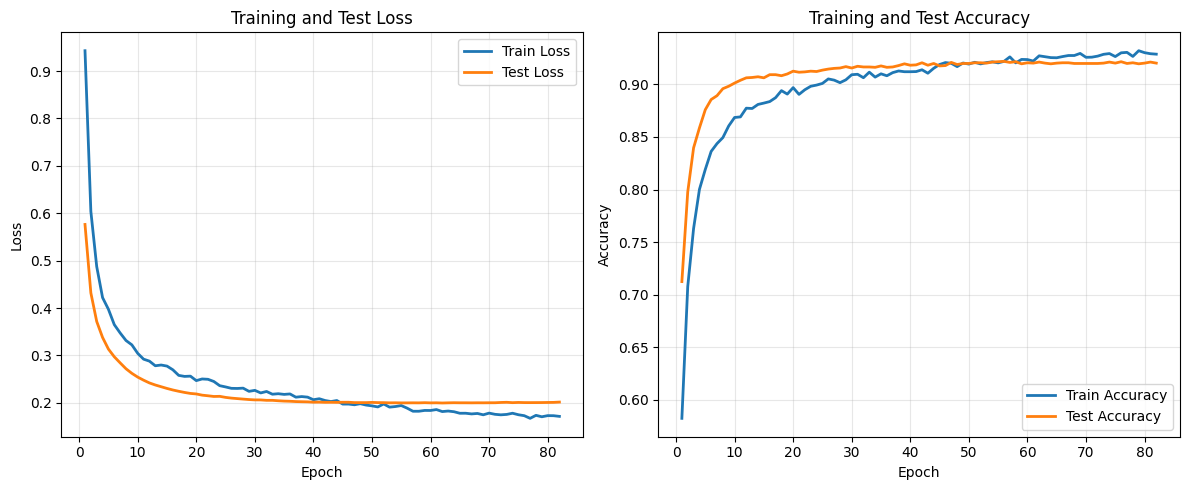


模型评估:

Train Set Evaluation Results:
Loss: 0.1325
Accuracy: 0.9499
Precision: 0.9457
Recall: 0.9546
F1 Score: 0.9501


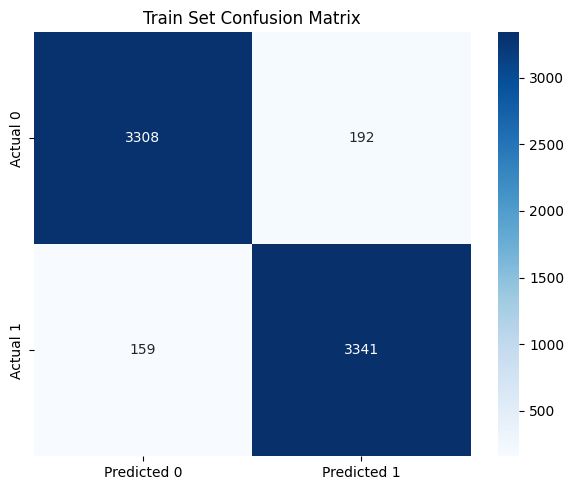


Test Set Evaluation Results:
Loss: 0.2014
Accuracy: 0.9203
Precision: 0.9081
Recall: 0.9353
F1 Score: 0.9215


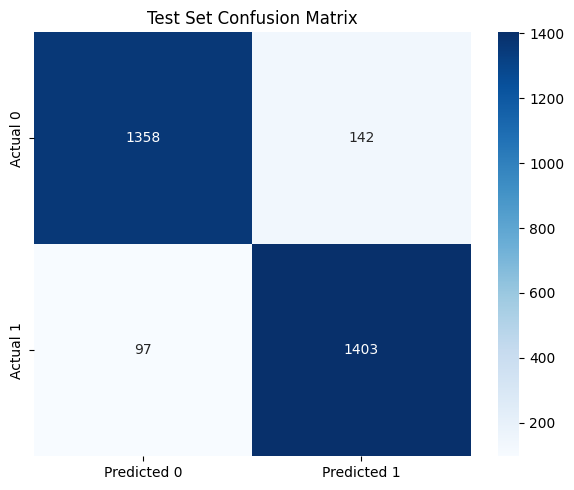


绘制决策边界...


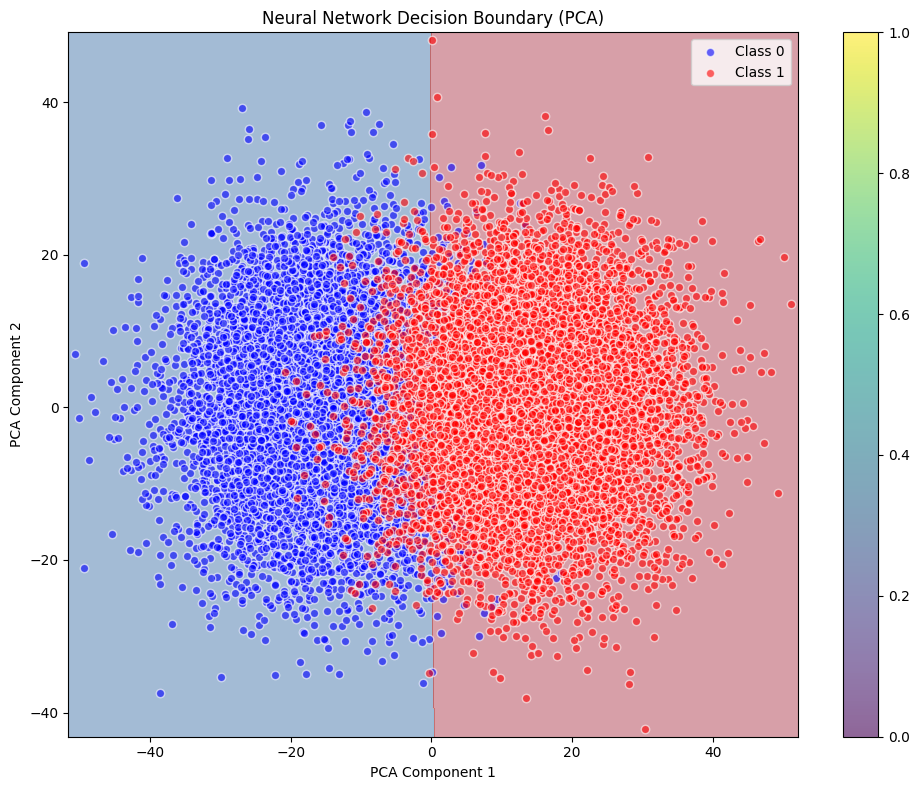


模型性能总结
训练集 - 准确率: 0.9499, 损失: 0.1325
测试集 - 准确率: 0.9203, 损失: 0.2014
训练轮次: 82


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 数据准备
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# 创建数据集和数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"训练批次数量: {len(train_loader)}")
print(f"测试批次数量: {len(test_loader)}")

# 定义神经网络模型
class FeedForwardNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(FeedForwardNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()  # 二分类使用Sigmoid
        )
        
    def forward(self, x):
        return self.network(x)

# 初始化模型 - 使用与手动实现相同的参数
input_dim = 200
hidden_dim = 128
output_dim = 1
dropout_rate = 0.3

model = FeedForwardNet(input_dim, hidden_dim, output_dim, dropout_rate).to(device)
print("网络结构:")
print(model)

# 定义损失函数和优化器 - 使用与手动实现相同的超参数
criterion = nn.BCELoss()  # 二元交叉熵损失
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)  # L2正则化

# 训练函数
def train_model(model, train_loader, test_loader, epochs=500, patience=20):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    best_test_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # 训练模式
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            # 前向传播
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
            
            # 计算训练准确率
            predicted = (outputs.squeeze() > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # 计算平均训练损失和准确率
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # 评估模式
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                test_loss += loss.item() * batch_X.size(0)
                
                # 计算测试准确率
                predicted = (outputs.squeeze() > 0.5).float()
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
        
        test_loss = test_loss / len(test_loader.dataset)
        test_accuracy = test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # 早停机制
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        # 打印训练进度
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')
        
        # 检查早停
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    # 加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    history = {
        'epochs': list(range(1, len(train_losses) + 1)),
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'test_loss': test_losses,
        'test_acc': test_accuracies
    }
    
    return history

# 评估函数
def evaluate_model(model, X_tensor, y_tensor, set_name="Dataset"):
    """评估模型性能"""
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = (outputs.squeeze() > 0.5).float().cpu().numpy()
        probabilities = outputs.squeeze().cpu().numpy()
    
    y_true = y_tensor.cpu().numpy()
    
    # 计算指标
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)
    f1 = f1_score(y_true, predictions)
    
    # 计算损失
    loss = criterion(outputs.squeeze(), y_tensor).item()
    
    print(f"\n{set_name} Evaluation Results:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # 绘制混淆矩阵
    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{set_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# 训练模型
print("开始训练...")
history = train_model(model, train_loader, test_loader, epochs=500, patience=20)

# 绘制训练历史
def plot_training_history(history, figsize=(12, 5)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # 损失曲线
    ax1.plot(history['epochs'], history['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(history['epochs'], history['test_loss'], label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 准确率曲线
    ax2.plot(history['epochs'], history['train_acc'], label='Train Accuracy', linewidth=2)
    ax2.plot(history['epochs'], history['test_acc'], label='Test Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 评估模型
print("\n模型评估:")
train_metrics = evaluate_model(model, X_train_tensor, y_train_tensor, "Train Set")
test_metrics = evaluate_model(model, X_test_tensor, y_test_tensor, "Test Set")

# 可视化决策边界（使用PCA降维）
def plot_decision_boundary_pca(model, X, y, device):
    """使用PCA降维绘制决策边界"""
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # 创建网格数据
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # 预测网格点
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_points_original = pca.inverse_transform(mesh_points)
    
    model.eval()
    with torch.no_grad():
        mesh_tensor = torch.FloatTensor(mesh_points_original).to(device)
        Z = model(mesh_tensor).cpu().numpy()
        Z = (Z > 0.5).astype(int).reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu_r')
    plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], c='blue', 
                label='Class 0', alpha=0.6, edgecolors='w')
    plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], c='red', 
                label='Class 1', alpha=0.6, edgecolors='w')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Neural Network Decision Boundary (PCA)')
    plt.legend()
    plt.colorbar()
    plt.tight_layout()
    plt.show()

print("\n绘制决策边界...")
plot_decision_boundary_pca(model, X, y, device)

# 打印最终模型性能总结
print("\n" + "="*50)
print("模型性能总结")
print("="*50)
print(f"训练集 - 准确率: {train_metrics['accuracy']:.4f}, 损失: {train_metrics['loss']:.4f}")
print(f"测试集 - 准确率: {test_metrics['accuracy']:.4f}, 损失: {test_metrics['loss']:.4f}")
print(f"训练轮次: {len(history['epochs'])}")
print("="*50)